In [175]:
from feature_engine.datetime import DatetimeFeatures
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
import sys
from xgboost import XGBRegressor

sys.path.append(str(Path().absolute().parent.parent))

from tsml.train.trainer import TSTrainer, CustomTimeSeriesSplit

In [247]:
# df = pd.read_parquet('../../data/walmart/processed/cat_id_sales.parquet').replace(-1, np.nan).dropna()
df = pd.read_parquet('../../data/walmart/processed/cat_id_sales.parquet').dropna()
df.shape

(5736, 26)

In [248]:
def multi_ts_train_test_split(X, y, window_split): ## test_size equal to the time horizon. Splits defines the rest
        if isinstance(X.index, pd.core.indexes.range.RangeIndex):
            idx_u = np.unique(X.index.values)
        else: 
            idx_u = X.index.unique()

        train_index = idx_u[ : -window_split]
        test_index  = idx_u[ -window_split : ]
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        return X_train, X_test, y_train, y_test

In [283]:
targets = ['y_0', 'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_7','y_8', 'y_9', 'y_10', 'y_11', 'y_12', 'y_13']
X_train, X_test, y_train, y_test = \
    multi_ts_train_test_split(df.set_index('date', drop=False), df.set_index('date', drop=False)[targets], 28)

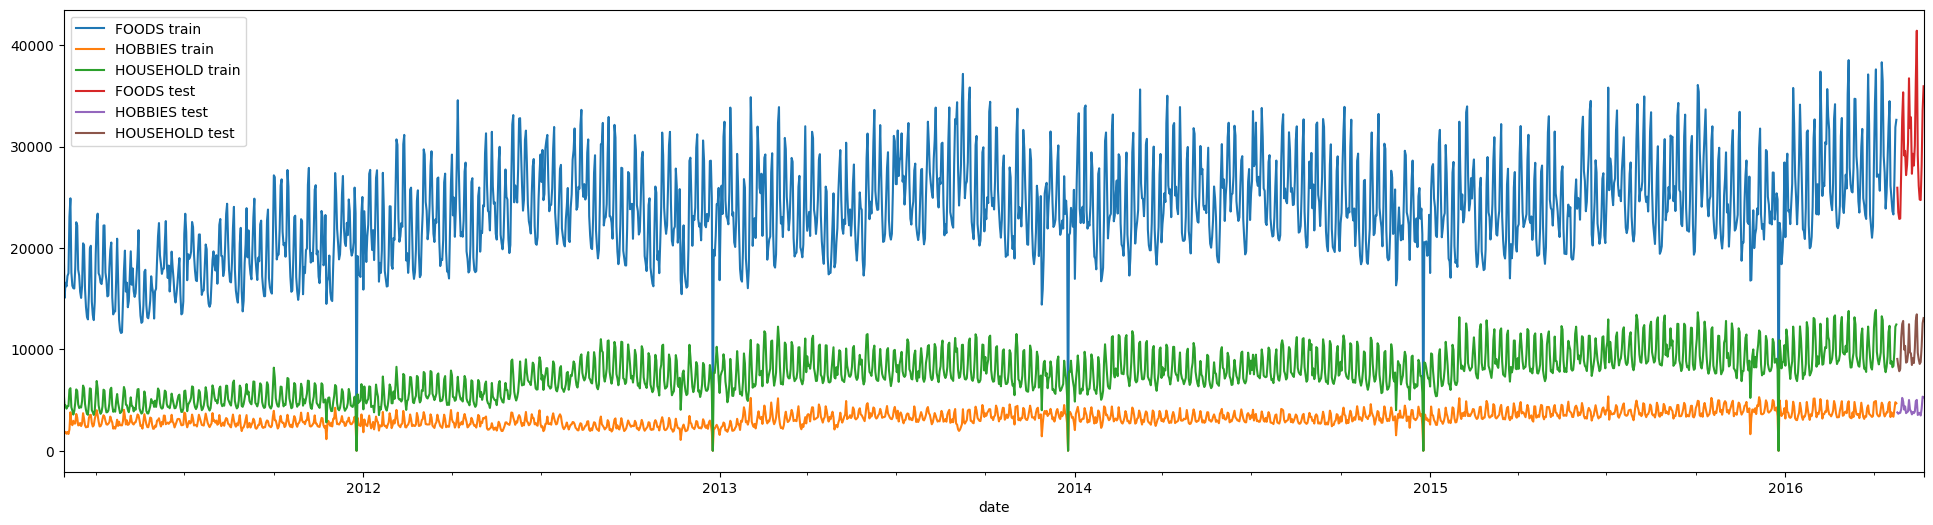

In [284]:
fig, ax= plt.subplots(figsize=(24,6))
for name, group in X_train.groupby('cat_id'):
    group.plot(y = 'y_0', ax=ax, label=f'{name} train')
for name, group in X_test.groupby('cat_id'):
    group.plot(y = 'y_0', ax=ax, label=f'{name} test')
plt.show()

In [259]:
categorical_columns_ohe = ['cat_id']
categorical_columns_ordinal = ['event_name_1', 'event_name_2']
date_column = ['date']
targets = ['y_0', 'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_7','y_8', 'y_9', 'y_10', 'y_11', 'y_12', 'y_13']

dt_transform = DatetimeFeatures(
    variables='date',
    features_to_extract=['year','month','week','day_of_week', 'day_of_month']
)

ohe = OneHotEncoder()
ordinal = OrdinalEncoder()

transformer = ColumnTransformer(
        transformers=[
            ('date_transform', dt_transform, date_column),
            ('categorical-ordinal', ordinal, categorical_columns_ordinal),
            ('categorical-ohe', ohe, categorical_columns_ohe),
            ('drop', 'drop', targets)
        ],
        remainder='passthrough',
    )

xgb_pipeline_1 = make_pipeline(transformer, XGBRegressor())
lgbm_pipeline_1 = make_pipeline(transformer,LGBMRegressor())
quantiles = [.05, .1, .25, .5, .75, .9, .95]
lgbm_quantile_pipeline_1 = make_pipeline(transformer,LGBMRegressor(alpha=quantiles))

In [267]:
xgb_pipeline_1.fit(X_train, y_train['y_0'])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date_transform',
                                                  DatetimeFeatures(features_to_extract=['year',
                                                                                        'month',
                                                                                        'week',
                                                                                        'day_of_week',
                                                                                        'day_of_month'],
                                                                   variables='date'),
                                                  ['date']),
                                                 ('categorical-ordinal',
                                                  OrdinalEncoder(),
                                                  ['event_name_1',
                                                   'event_name_2']),
                                                 ('categorical-ohe',
                                                  OneHotEncoder(), ['cat_id']),
                                                 (...
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [268]:
lgbm_pipeline_1.fit(X_train, y_train['y_0'])

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date_transform',
                                                  DatetimeFeatures(features_to_extract=['year',
                                                                                        'month',
                                                                                        'week',
                                                                                        'day_of_week',
                                                                                        'day_of_month'],
                                                                   variables='date'),
                                                  ['date']),
                                                 ('categorical-ordinal',
                                                  OrdinalEncoder(),
                                                  ['event_name_1',
                                                   'event_name_2']),
                                                 ('categorical-ohe',
                                                  OneHotEncoder(), ['cat_id']),
                                                 ('drop', 'drop',
                                                  ['y_0', 'y_1', 'y_2', 'y_3',
                                                   'y_4', 'y_5', 'y_6', 'y_7',
                                                   'y_8', 'y_9', 'y_10', 'y_11',
                                                   'y_12', 'y_13'])])),
                ('lgbmregressor', LGBMRegressor())])

In [276]:
params = {
    'objective': 'quantile',
    'metric': 'quantile',
    'max_depth': 4,
    'num_leaves': 15,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'boosting_type': 'gbdt'
}

quantiles = [.05, .1, .25, .5, .75, .9, .95]
lgbm_quantile = []
predictions = {}
for q in quantiles:
    lgbm_model = make_pipeline(transformer,LGBMRegressor(alpha=q, **params))
    lgbm_model.fit(X_train, y_train['y_0'])
    predictions[f'{q}'] = lgbm_model.predict(X_test)

In [270]:
y_test['cat_id'] = X_test['cat_id']
y_test['xgb_y_1'] = xgb_pipeline_1.predict(X_test)
y_test['lgbm_y_1'] = lgbm_pipeline_1.predict(X_test)

for k, v in predictions.items():
    y_test[f'lgbm_q_{k}'] = v

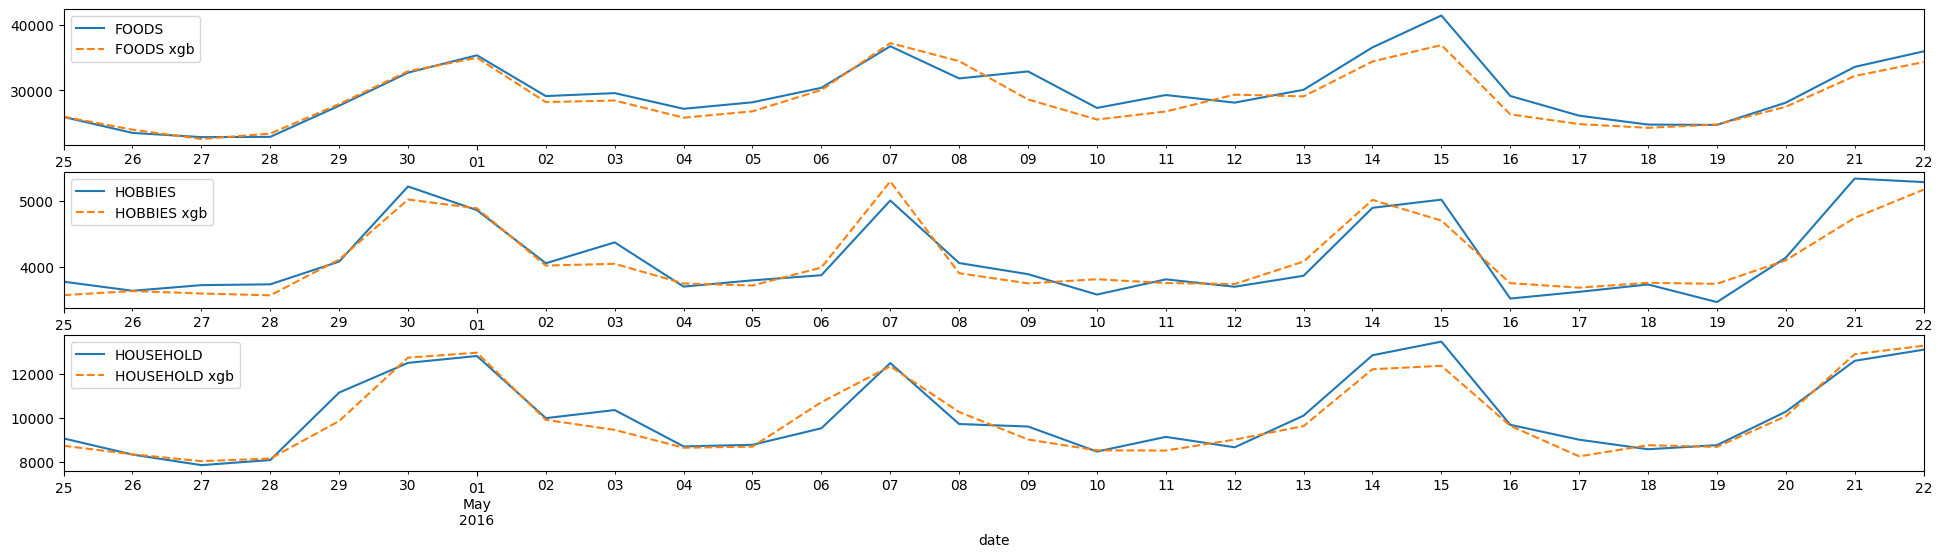

In [271]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24,6))

for (name, group), ax in zip(y_test.groupby('cat_id'), (ax1, ax2, ax3)):
    group.plot(y='y_0', ax=ax, linestyle= 'solid', label=name)
    group.plot(y='xgb_y_0', ax=ax, linestyle= 'dashed', label=f'{name} xgb')

plt.show()

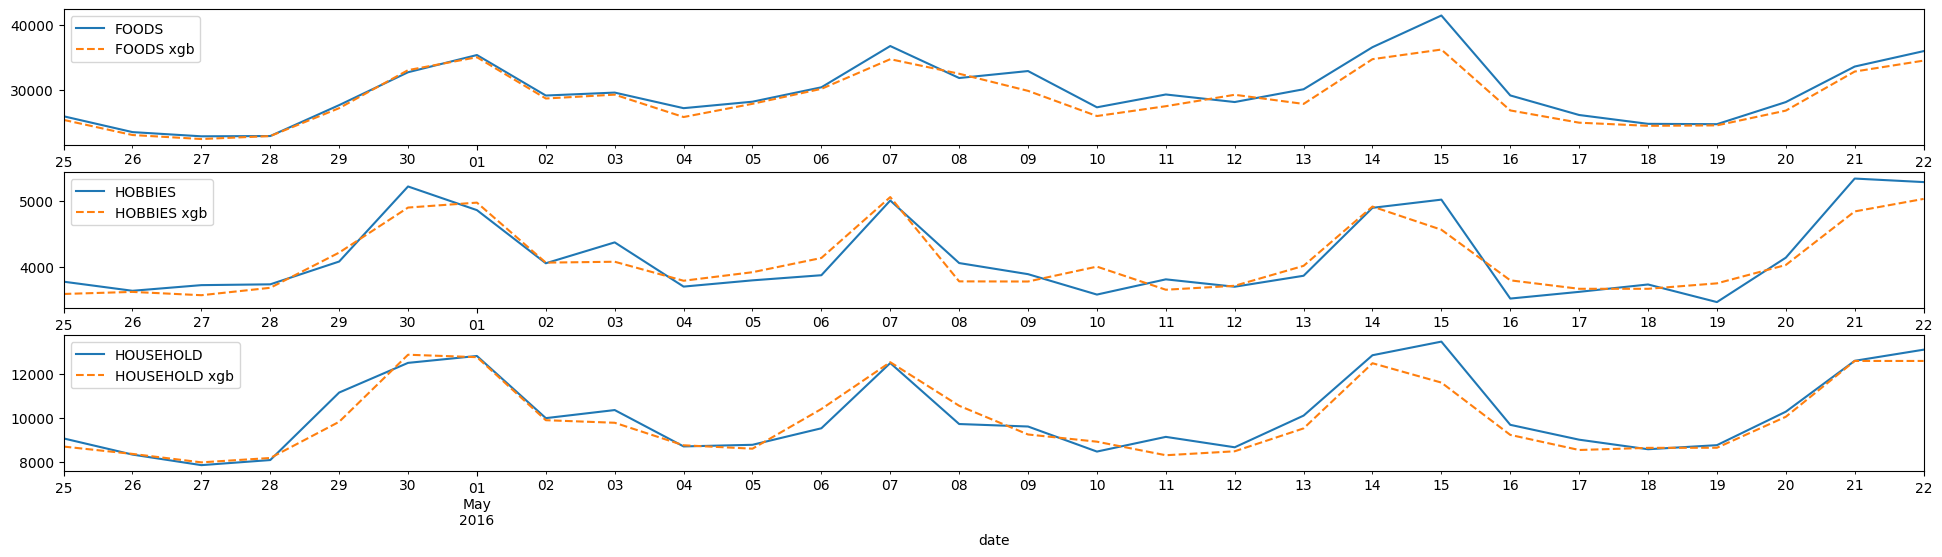

In [272]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24,6))

for (name, group), ax in zip(y_test.groupby('cat_id'), (ax1, ax2, ax3)):
    group.plot(y='y_0', ax=ax, linestyle= 'solid', label=name)
    group.plot(y='lgbm_y_0', ax=ax, linestyle= 'dashed', label=f'{name} xgb')

plt.show()

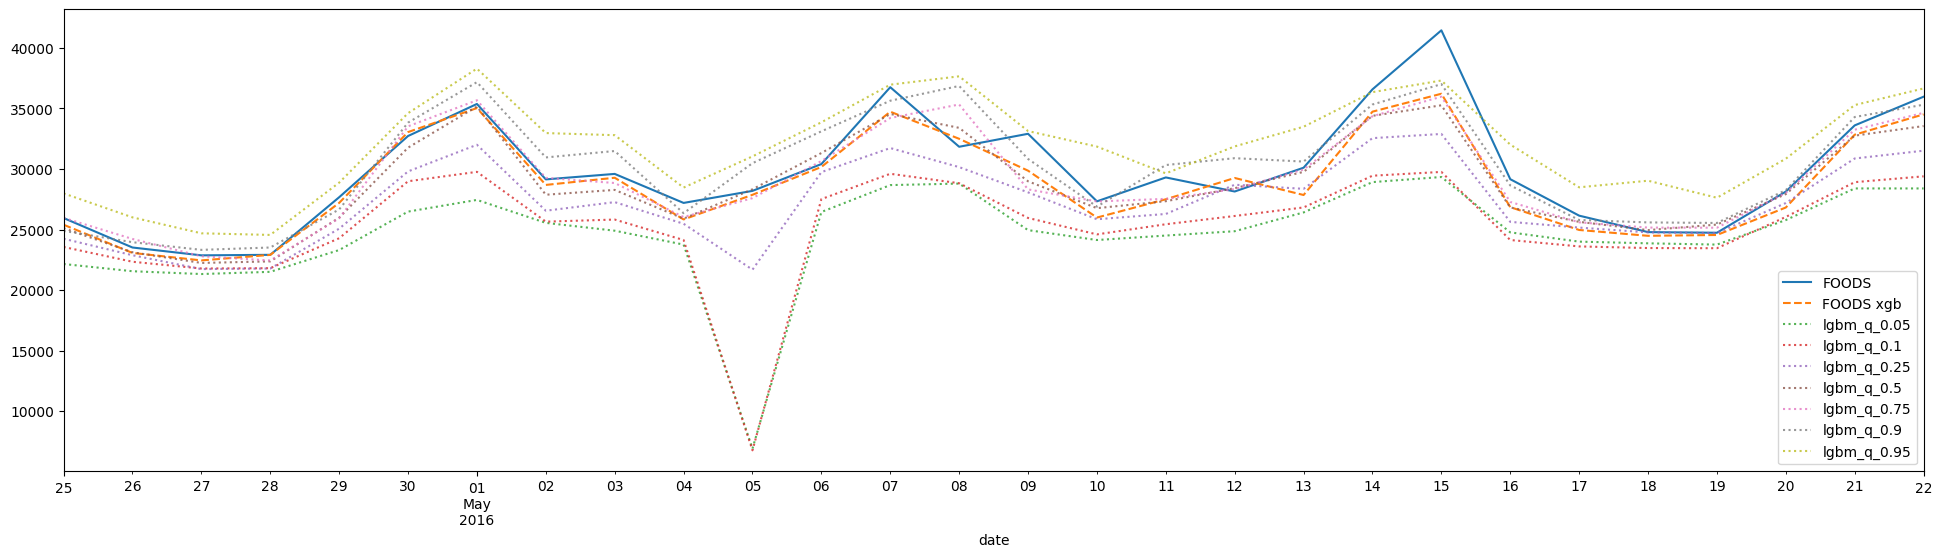

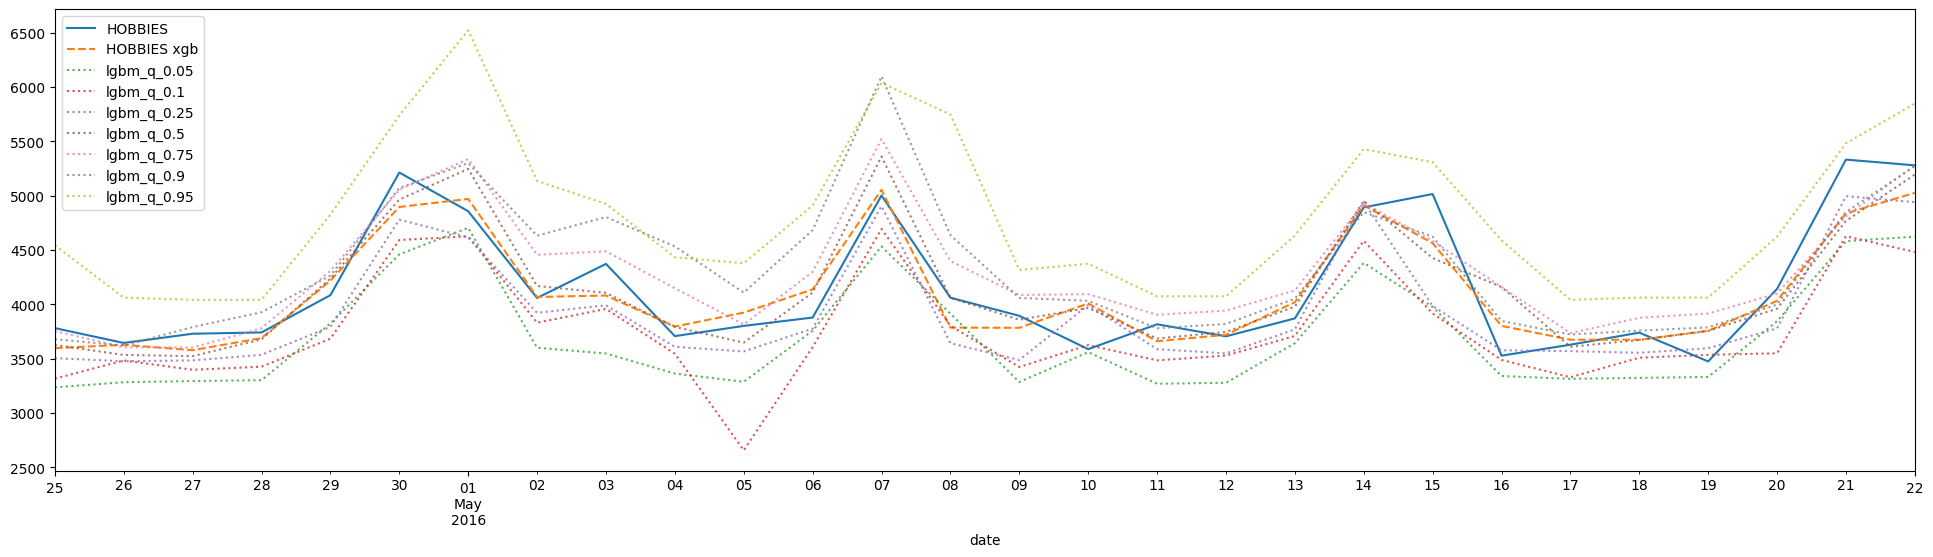

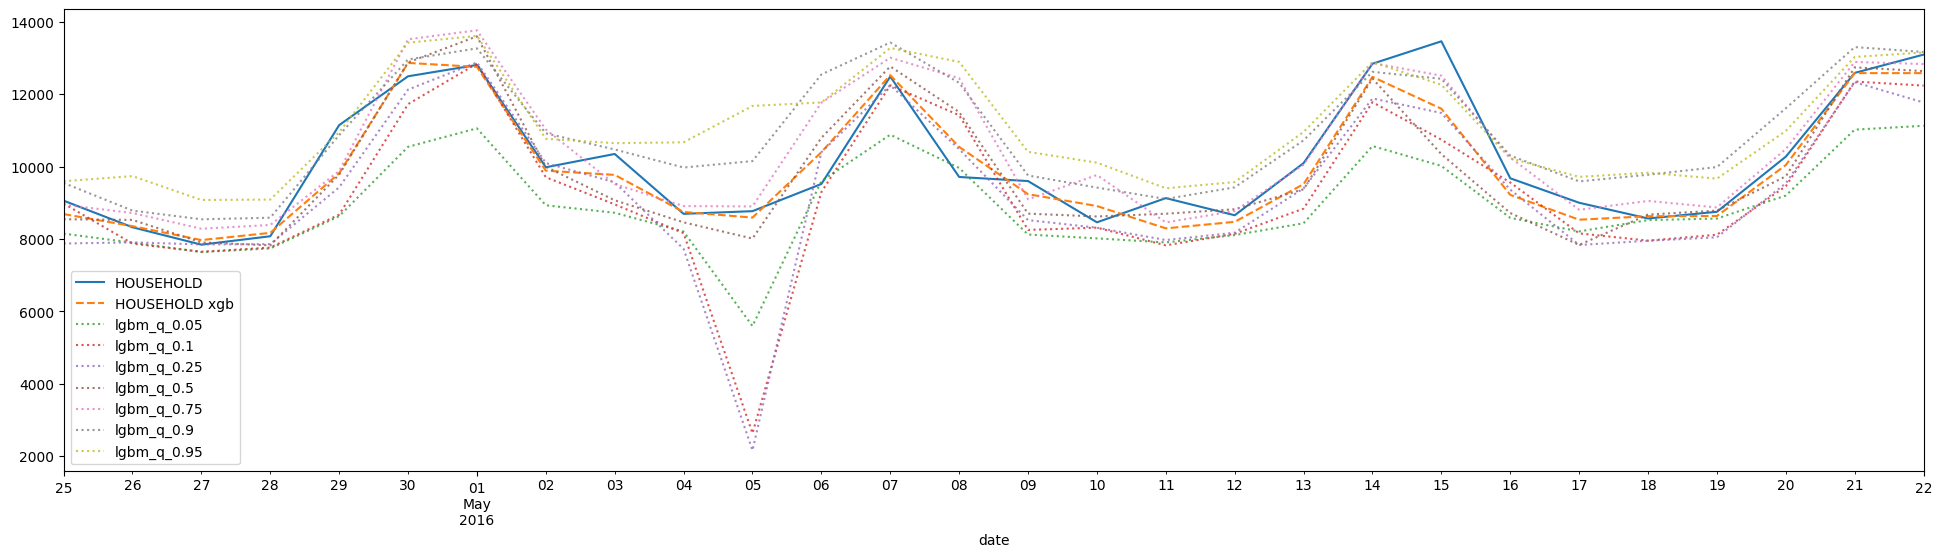

In [274]:


for (name, group) in y_test.groupby('cat_id'):
    fig, ax= plt.subplots(figsize=(24,6))
    group.plot(y='y_0', ax=ax, linestyle= 'solid', label=name)
    group.plot(y='lgbm_y_0', ax=ax, linestyle= 'dashed', label=f'{name} xgb')
    for col in [c for c in y_test.columns if 'q_' in c]:
        group.plot(y=col, ax=ax, linestyle= 'dotted', label=f'{col}', alpha=0.8)

plt.show()